In [18]:
from OmniTokenizer import OmniTokenizer_VQGAN
from IPython.display import HTML
from einops import rearrange, repeat, pack
import torchshow as ts
vqgan_ckpt = '/mnt/bn/shuhuairen-7fa7529b/ckpt/OmniTokenizer/imagenet_k600.ckpt'
vqgan = OmniTokenizer_VQGAN.load_from_checkpoint(vqgan_ckpt, strict=False)
vqgan.eval()

# tokens = vqgan.encode(img)
# recons = vqgan.decode(tokens)

loaded pretrained LPIPS loss from /mnt/bn/shuhuairen-7fa7529b/code/OmniTokenizer/OmniTokenizer/modules/cache/vgg.pth


VQGAN(
  (encoder): OmniTokenizer_Encoder(
    (temporal_pool): Identity()
    (spatial_pool): Identity()
    (to_patch_emb_first_frame): Sequential(
      (0): Rearrange('b c 1 (h p1) (w p2) -> b 1 h w (c p1 p2)', p1=8, p2=8)
      (1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (2): Linear(in_features=192, out_features=512, bias=True)
      (3): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (to_patch_emb): Sequential(
      (0): Rearrange('b c (t pt) (h p1) (w p2) -> b t h w (c pt p1 p2)', p1=8, p2=8, pt=4)
      (1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (2): Linear(in_features=768, out_features=512, bias=True)
      (3): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (enc_spatial_transformer): Transformer(
      (layers): ModuleList(
        (0-1): 2 x ModuleList(
          (0): PEG(
            (dsconv): Conv3d(512, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), groups=512)
          )
          (1): Attentio

In [16]:
from OmniTokenizer.video_utils import VideoNorm, load_video_from_path_decord, VideoRandomSquareCrop
import torch

video_path = '/mnt/bn/shuhuairen-7fa7529b/data/UCF-101/videos/ApplyEyeMakeup/v_ApplyEyeMakeup_g25_c07.avi'
frames, _ = load_video_from_path_decord(
    video_path,
    frm_sampling_strategy="center",
    fps=8,
    num_frm=17,
    height=128,
    width=128,
)  # T, H, W, 3
resolution = 64
video_random_cropper = VideoRandomSquareCrop(resolution)
norm = VideoNorm()

# frames = video_random_cropper(frames)
vid_frm_array = (
            torch.from_numpy(frames).float().permute(0, 3, 1, 2)
        ) # T, 3, H, W
video = norm(vid_frm_array).permute(1, 0, 2, 3).unsqueeze(0)
print(video.shape)
tokens = vqgan.encode(video, is_image=False)

torch.Size([1, 3, 17, 128, 128])


In [4]:
print(video.min(), video.max())

tensor(-0.5000) tensor(0.5000)


In [4]:
tokens

tensor([[[[ 344, 4133, 6843,  ..., 3769, 2992, 7716],
          [2720, 3963, 5211,  ..., 5848,   91, 4174],
          [4950, 6527, 7731,  ...,  556, 5386,  518],
          ...,
          [6251, 2487, 7798,  ..., 7698, 2466, 5363],
          [3159, 3512, 3702,  ...,  994, 2085, 3192],
          [7778,  199, 7873,  ..., 4505, 2900, 8189]],

         [[2639, 4022, 2716,  ...,  193, 6559, 5100],
          [ 469, 2775, 6641,  ..., 1430, 7738, 4189],
          [ 147, 4013, 2050,  ..., 1568, 5277, 3701],
          ...,
          [3275, 7477, 1129,  ...,  926, 6627,  844],
          [5657, 3594, 7474,  ..., 6436, 7749,   64],
          [1958, 5011, 3685,  ..., 3262, 5672, 1915]],

         [[6428,  746, 2219,  ..., 3327, 6734, 3345],
          [3737, 4052, 1491,  ..., 2919, 1403, 4311],
          [ 241, 6269,  693,  ..., 7143, 2554,  471],
          ...,
          [6770, 1962, 7789,  ..., 3335, 3832,  867],
          [6525,  389, 3066,  ..., 3355, 3617, 7692],
          [7205,  964, 5986,  ...

In [17]:
recons = vqgan.decode(tokens, is_image=False)
recons = recons + 0.5
recons = torch.clamp(recons, 0, 1)

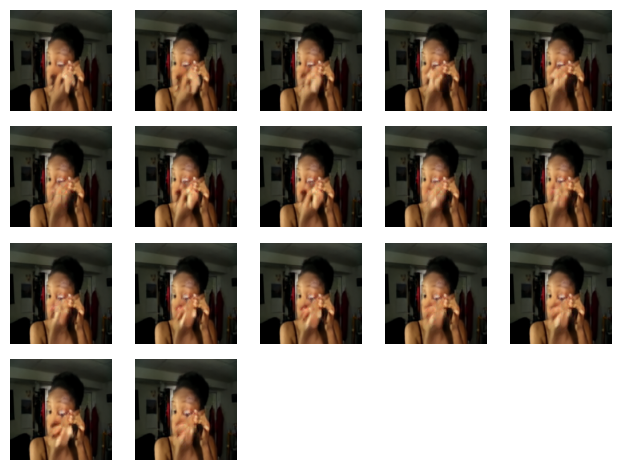

In [19]:
ts.show(rearrange(recons[0], 'c t h w->t c h w'))

(17, 3, 128, 128)


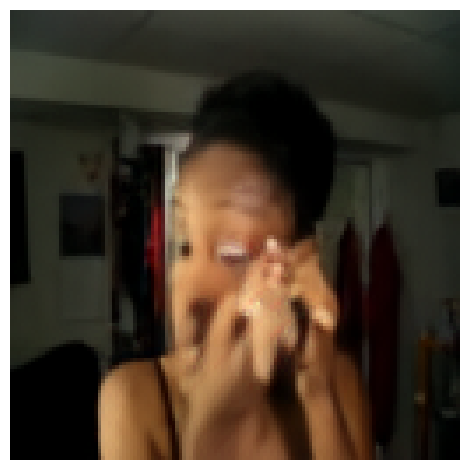

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


In [20]:
ani = ts.show_video(rearrange(recons[0], 'c t h w->t c h w'))
HTML(ani.to_jshtml())

(17, 3, 128, 128)


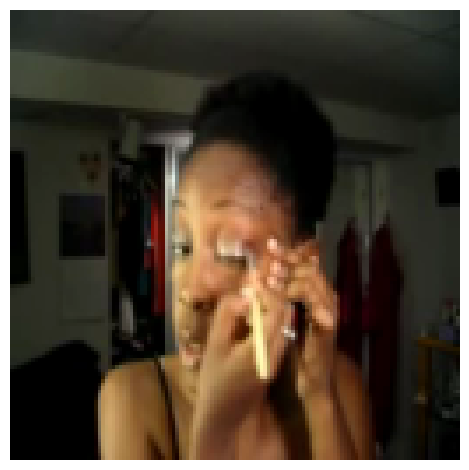

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


In [23]:
ani = ts.show_video(vid_frm_array)
HTML(ani.to_jshtml())